<center>
<h3>Agents Example(creating custom agents)</h3>
<h4>Below we can see the example that how agents help LLM to call the tools</h4>
</center>

## Agents

<p>By themselves language model can't take actions- they just ouput text</p>
<p>Agents are system that use LLM as a reasoning engine to determine which action to take(means which tool should be called.) and what the input to those actions should be. The result of those action can be feed back into the agent and it determine whether more actions are needed or whether it is okay to finish.</p>

<p><code>LangGraph</code> is used to create highly controllable and cutomizable agents</p>

In [18]:
from langgraph.graph import START,END,StateGraph #for graph
from langchain_core.tools import BaseTool # for tools 
from pydantic import BaseModel,Field # for type
from typing import Optional,Type,Literal,TypedDict
from langchain_core.callbacks import CallbackManagerForToolRun,AsyncCallbackManagerForToolRun



#### Tool using BaseTool

In [17]:
class BaseInputType(BaseModel):
    a : int = Field("First Number")
    b: int = Field("Second Number")

class BaseOutputType(BaseModel):
    c : int = Field("Result")
    
# Tool Implementation

# Note: It's important that every field has type hints. BaseTool is a
# Pydantic class and not having type hints can lead to unexpected behavior.

class SimpleCalculator(BaseTool):
    name : str = "Simple Calculator"
    description : str = "Helpful for simple math question"
    args_schema: Type[BaseModel] = BaseInputType
    return_direct:bool = True
    
    
    # for normal calls
    def _run(self,a : int,b:int,run_manager:Optional[CallbackManagerForToolRun] = None) -> BaseOutputType:
        return a*b
    
    # If the calculation is cheap, you can just delegate to the sync implementation
    # as shown below.
    # If the sync calculation is expensive, you should delete the entire _arun method.
    # LangChain will automatically provide a better implementation that will
    # kick off the task in a thread to make sure it doesn't block other async code. 
        
    # for async calls
    async def _arun(self,a:int,b:int, run_manager:Optional[AsyncCallbackManagerForToolRun] = None)->BaseOutputType:
        return self._run(a,b,run_manager)

# checking the tool
multiply = SimpleCalculator()

In [5]:
print(multiply.name)
print(multiply.description)
print(multiply.args_schema)

Simple Calculator
Helpful for simple math question
<class '__main__.BaseInputType'>


In [15]:
print(multiply.invoke({"a":2,"b":3}))
print(await multiply.ainvoke({"a":25,"b":25}))

6
625


#### <font style="color:green">Simple agent  implementation using LangGraph</font>

In [29]:
# Type of state
class State(TypedDict):
    first_num : int
    sec_num : int
    result : int

# Defining the functionality of Node
def node_1(state):
    # let's update the state in node 1
    print("--- Inside Node 1 (Updating the state) ---- \n")
    print("State : ",state,"\n")
    return ({"first_num" : state["first_num"], "sec_num":state["sec_num"]})

def node_2(state):
    print("---- Inside Node 2 (returning multiply) ----\n")
    return({"result":state["first_num"] * state["sec_num"]})

def node_3(state):
    print("---- Inside node 3 (returning addition) ----\n")
    return({"result" : state["first_num"] + state["sec_num"]})

def deciding_node(state)-> Literal["node_2","node_3"]:
    if state["first_num"] < state["sec_num"]:
        return "node_2"
    return "node_3"

# Creating Graph
builder = StateGraph(State)

# Adding node to graph
builder.add_node("node_1",node_1)
builder.add_node("node_2",node_2)
builder.add_node("node_3",node_3)

# Adding edge between graph
builder.add_edge(START,"node_1")
builder.add_conditional_edges("node_1",deciding_node)
builder.add_edge("node_2",END)
builder.add_edge("node_3",END)

# at last compiling the graph
graph = builder.compile()

In [30]:
graph.invoke({"first_num":10,"sec_num":30})

--- Inside Node 1 (Updating the state) ---- 

State :  {'first_num': 10, 'sec_num': 30} 

---- Inside Node 2 (returning multiply) ----



{'first_num': 10, 'sec_num': 30, 'result': 300}

In [31]:
graph.invoke({"first_num":100,"sec_num":30})

--- Inside Node 1 (Updating the state) ---- 

State :  {'first_num': 100, 'sec_num': 30} 

---- Inside node 3 (returning addition) ----



{'first_num': 100, 'sec_num': 30, 'result': 130}

#### <code><strong>Exmaple of 4 key concept using agent</strong></code>
<ul>
<li>Using <code>Chat message</code> in our graph</li>
<li>using <code>Chat Models </code></li>
<li><code>Binding tools</code> to LLM</li>
<li>Executing <code>toolcall</code> in graph</li>
</ul>

#### Message
--desc-- chain timestamp : 0.31

In [13]:
from pprint import pprint
from langchain_core.messages import AIMessage,HumanMessage,SystemMessage
messages = [AIMessage(content="So you said you were searching ocean manmals?",role="model",name="model")]
messages.extend([HumanMessage(content="Yes that's right.", role="user",name="user")])
messages.extend([AIMessage(content="Great, what would you like to learn about", role="model",name="model")])
messages.extend([HumanMessage(content="I want to learn about the whale in ocean",role="user",name="user")])

for m in messages:
    print(m.pretty_print())

================================== Ai Message ==================================
Name: model

So you said you were searching ocean manmals?
None
================================ Human Message =================================
Name: user

Yes that's right.
None
================================== Ai Message ==================================
Name: model

Great, what would you like to learn about
None
================================ Human Message =================================
Name: user

I want to learn about the whale in ocean
None


#### Chat Models
--desc 1.03

In [16]:
from langchain_community.llms.ollama import Ollama
llm = Ollama(model="llama3.1")
result = llm.invoke(messages)
type(result)

str

In [18]:
print(result)

There are so many fascinating things about whales.

Let's dive into it (pun intended). Whales are massive marine mammals that belong to the order Cetacea. There are two suborders: toothed whales (Odontoceti) and baleen whales (Mysticeti).

Toothed whales include dolphins, porpoises, and sperm whales. They have a highly developed sense of hearing and echolocation, which helps them navigate and hunt in the dark depths of the ocean.

Baleen whales, on the other hand, are filter feeders that use their baleen plates to strain tiny crustaceans, plankton, and small fish from the water. The largest animal to have ever existed on Earth is a blue whale, which can grow up to 100 feet (30 meters) in length and weigh around 200 tons!

Some interesting facts about whales include:

* Whales are highly social creatures that often live in groups called pods.
* They are incredibly intelligent animals that have been observed using complex behaviors like cooperative hunting and even playing.
* Some specie

In [21]:
# Implement tool yo give below capability TODO

In [20]:
print(llm.invoke([HumanMessage(content="what's the day today",role="user")]))

I'm happy to help, but I don't have real-time access to your current date and time. However, I can suggest a few options:

1. **Check your phone or computer**: Take a look at the clock on your device to see the current date.
2. **Use an online calendar**: Websites like Google Calendar, Apple Calendar, or any other digital calendar you might use should be able to tell you the day of the week and date.
3. **Ask me about general information**: If you're looking for something specific (e.g., today's weather forecast), feel free to ask!

Which option sounds most convenient for you?


#### Tools
---dec 1.32

In [3]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
# API keys and Lang Smith 
import os
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
llm = ChatOpenAI(model="gpt-4o-mini")


In [17]:
from langchain_core.tools import Tool
from langchain_core.tools import tool

@tool
def multiply(a : int,b:int) -> int:
    """Add two integers.

    Args:
        a: First integer
        b: Second integer
    """
    return a*b

# Bind the tool to the LLM
llm_with_tool = llm.bind_tools([multiply])

In [18]:
query = "What is 3 * 12?"

ai_message = llm_with_tool.invoke(query)

In [19]:
print(ai_message)

content='' additional_kwargs={'tool_calls': [{'id': 'call_XysdXilX82HhY4Tsg6mCnC78', 'function': {'arguments': '{"a":3,"b":12}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 65, 'total_tokens': 82, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_e2bde53e6e', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-1ac203e1-161c-46b9-8435-da4322c61f88-0' tool_calls=[{'name': 'multiply', 'args': {'a': 3, 'b': 12}, 'id': 'call_XysdXilX82HhY4Tsg6mCnC78', 'type': 'tool_call'}] usage_metadata={'input_tokens': 65, 'output_tokens': 17, 'total_tokens': 82}


In [20]:
ai_msg = ai_message
ai_msg.tool_calls[0]

{'name': 'multiply',
 'args': {'a': 3, 'b': 12},
 'id': 'call_XysdXilX82HhY4Tsg6mCnC78',
 'type': 'tool_call'}

In [31]:
ai_msg

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_XysdXilX82HhY4Tsg6mCnC78', 'function': {'arguments': '{"a":3,"b":12}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 65, 'total_tokens': 82, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_e2bde53e6e', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1ac203e1-161c-46b9-8435-da4322c61f88-0', tool_calls=[{'name': 'multiply', 'args': {'a': 3, 'b': 12}, 'id': 'call_XysdXilX82HhY4Tsg6mCnC78', 'type': 'tool_call'}], usage_metadata={'input_tokens': 65, 'output_tokens': 17, 'total_tokens': 82})

#### Binding Tool to LLM(use ChatOpenAI model)

In [1]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini")
toolkit= [] # list of tools
llm_tool = llm.bind_tools(toolkit)

#### Calling Tools when LLM needs it

In [2]:
from IPython.display import display,Image
from langgraph.graph.message import MessagesState
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import START,StateGraph
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage,SystemMessage
from pprint import pprint
from dotenv import load_dotenv

load_dotenv()

True

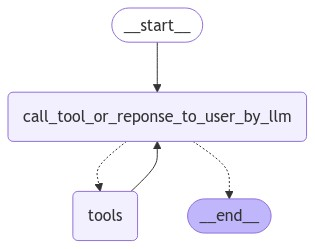

In [29]:
# tools
def add(a:int,b:int)-> int:
    """Help To add two numbers

    Args:
        a : First Number
        b : Second Number

    Returns:
        int : Result Output
    """
    return a+b

def multiply(a:int,b:int)-> int:
    """Help To multiply two numbers

    Args:
        a : First Number
        b : Second Number

    Returns:
        int : Result Output
    """
    return a*b
llm = ChatOpenAI(model="gpt-4o-mini")
llm_tools = llm.bind_tools([add,multiply])


# node
def call_tool_or_reponse_to_user_by_llm(state:MessagesState):
    return {"messages":[llm_tools.invoke(state['messages'])]}  # here deciosion will be taken place wether to call the tool or reponse directly to the user

builder = StateGraph(MessagesState)
builder.add_node("call_tool_or_reponse_to_user_by_llm",call_tool_or_reponse_to_user_by_llm)
builder.add_node("tools",ToolNode([add,multiply]))

builder.add_edge(START,"call_tool_or_reponse_to_user_by_llm")
builder.add_conditional_edges("call_tool_or_reponse_to_user_by_llm",tools_condition) # routing between "__end__" or "tools call"
builder.add_edge("tools","call_tool_or_reponse_to_user_by_llm")

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))



In [12]:
def display_message(response):
    for message in response['messages']:
        print(message.pretty_print())

In [4]:
query = "Hey How are you doing?"
response = graph.invoke({"messages":HumanMessage(content=query,role = 'user')})

In [5]:
response

{'messages': [HumanMessage(content='Hey How are you doing?', additional_kwargs={}, response_metadata={}, id='c68e4804-2db4-459a-a029-6edeac0e7c37', role='user'),
  AIMessage(content="I'm just a program, so I don't have feelings, but I'm here and ready to help you! How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 89, 'total_tokens': 117, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_e2bde53e6e', 'finish_reason': 'stop', 'logprobs': None}, id='run-eddeb042-1ef2-497c-b9f2-03ea7a458ba5-0', usage_metadata={'input_tokens': 89, 'output_tokens': 28, 'total_tokens': 117, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})]}

In [13]:
display_message(response)

================================ Human Message =================================

Hey How are you doing?
None
================================== Ai Message ==================================

I'm just a program, so I don't have feelings, but I'm here and ready to help you! How can I assist you today?
None


In [6]:
query = "what is 2 multiply by 2"
response1 = graph.invoke({"messages":HumanMessage(content=query,role = 'user')})

In [7]:
response1

{'messages': [HumanMessage(content='what is 2 multiply by 2', additional_kwargs={}, response_metadata={}, id='704d73d5-6f5d-4004-97c6-8c415cab9dd3', role='user'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_DDPTpQUs25jXqecW6D2tA3WI', 'function': {'arguments': '{"a":2,"b":2}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 91, 'total_tokens': 108, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_e2bde53e6e', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5ca85a91-6e8a-46f7-a2a7-36ebed3695d6-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 2}, 'id': 'call_DDPTpQUs25jXqecW6D2tA3WI', 'type': 'tool_call'}], usage_metadata={'input_tokens': 91, 'output_tokens': 17, 'total_tokens': 108, 'input_tok

In [14]:
display_message(response1)


================================ Human Message =================================

what is 2 multiply by 2
None
================================== Ai Message ==================================
Tool Calls:
  multiply (call_DDPTpQUs25jXqecW6D2tA3WI)
 Call ID: call_DDPTpQUs25jXqecW6D2tA3WI
  Args:
    a: 2
    b: 2
None
================================= Tool Message =================================
Name: multiply

4
None
================================== Ai Message ==================================

2 multiplied by 2 equals 4.
None


In [8]:
query = "what is 2 +  2"
response2 = graph.invoke({"messages":HumanMessage(content=query,role = 'user')})

In [9]:
response2

{'messages': [HumanMessage(content='what is 2 +  2', additional_kwargs={}, response_metadata={}, id='a65d029a-bc07-49bf-9700-f1aef31caf8c', role='user'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_SnoZ1WRbaOtflTq1OYwWAzNf', 'function': {'arguments': '{"a":2,"b":2}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 91, 'total_tokens': 108, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_e2bde53e6e', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1875182c-5b73-4891-ac97-6abe0988f497-0', tool_calls=[{'name': 'add', 'args': {'a': 2, 'b': 2}, 'id': 'call_SnoZ1WRbaOtflTq1OYwWAzNf', 'type': 'tool_call'}], usage_metadata={'input_tokens': 91, 'output_tokens': 17, 'total_tokens': 108, 'input_token_details': {'cach

In [15]:
display_message(response2)


================================ Human Message =================================

what is 2 +  2
None
================================== Ai Message ==================================
Tool Calls:
  add (call_SnoZ1WRbaOtflTq1OYwWAzNf)
 Call ID: call_SnoZ1WRbaOtflTq1OYwWAzNf
  Args:
    a: 2
    b: 2
None
================================= Tool Message =================================
Name: add

4
None
================================== Ai Message ==================================

2 + 2 equals 4.
None


In [10]:
query = "what is 2 +  2 and multiply it by 10."
response3 = graph.invoke({"messages":HumanMessage(content=query,role = 'user')})

In [16]:
response3

{'messages': [HumanMessage(content='what is 2 +  2 and multiply it by 10.', additional_kwargs={}, response_metadata={}, id='0b34cb0f-6635-4bf6-919c-12fcc7ddbe41', role='user'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_wfZugVjIL5oyf7CszvYJtLml', 'function': {'arguments': '{"a": 2, "b": 2}', 'name': 'add'}, 'type': 'function'}, {'id': 'call_Ukx2qJ2ZCHT4RW1il8xDoIik', 'function': {'arguments': '{"a": 4, "b": 10}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 98, 'total_tokens': 148, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_e2bde53e6e', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-423e6919-efd9-4f62-a7fd-e7adf3567735-0', tool_calls=[{'name': 'add', 'args': {'a': 2, 'b': 2}, 'id': 'call_wf

In [17]:
display_message(response3)


================================ Human Message =================================

what is 2 +  2 and multiply it by 10.
None
================================== Ai Message ==================================
Tool Calls:
  add (call_wfZugVjIL5oyf7CszvYJtLml)
 Call ID: call_wfZugVjIL5oyf7CszvYJtLml
  Args:
    a: 2
    b: 2
  multiply (call_Ukx2qJ2ZCHT4RW1il8xDoIik)
 Call ID: call_Ukx2qJ2ZCHT4RW1il8xDoIik
  Args:
    a: 4
    b: 10
None
================================= Tool Message =================================
Name: add

4
None
================================= Tool Message =================================
Name: multiply

40
None
================================== Ai Message ==================================

The result of \(2 + 2\) is \(4\), and when you multiply it by \(10\), the result is \(40\).
None


now query is = Add 5 to the <code>result</code>

As graph don't have access to memory currently it don't what is result here.
i.e Ans will be wrong

In [19]:
query = "And Add 5 to the result"
response4 = graph.invoke({"messages":HumanMessage(content=query,role = 'user')})

In [20]:
display_message(response4)

================================ Human Message =================================

And Add 5 to the result
None
================================== Ai Message ==================================
Tool Calls:
  add (call_ST8eyKt8bg6J7IMwt8sbnqJ1)
 Call ID: call_ST8eyKt8bg6J7IMwt8sbnqJ1
  Args:
    a: 5
    b: 0
None
================================= Tool Message =================================
Name: add

5
None
================================== Ai Message ==================================

The result of adding 5 to 0 is 5.
None


# <font color="green">Agent With Memory</font>
Giving access to memory to graph.

In [33]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
memory.memory={}  # clearing out any previous saved checkpoint.
react_graph_memory = builder.compile(checkpointer=memory)  # calling out graph object to attach memory


In [34]:
config = {"configurable":{"thread_id":1}}
query1 = "what is 2 multiply 2"
response5 = react_graph_memory.invoke({"messages":HumanMessage(content=query1,role = 'user')},config=config)
display_message(response5)

================================ Human Message =================================

what is 2 multiply 2
None
================================== Ai Message ==================================
Tool Calls:
  multiply (call_8m4tGktkc6esnPSe27y0GuXh)
 Call ID: call_8m4tGktkc6esnPSe27y0GuXh
  Args:
    a: 2
    b: 2
None
================================= Tool Message =================================
Name: multiply

4
None
================================== Ai Message ==================================

2 multiplied by 2 is 4.
None


In [35]:
query2 = "And Add 10 to the previous esult"
response6 = react_graph_memory.invoke({"messages":HumanMessage(content=query2,role = 'user')},config=config)

Now it has the access to the memory. As it knows what is previous result.

In [37]:
display_message(response6)

================================ Human Message =================================

what is 2 multiply 2
None
================================== Ai Message ==================================
Tool Calls:
  multiply (call_8m4tGktkc6esnPSe27y0GuXh)
 Call ID: call_8m4tGktkc6esnPSe27y0GuXh
  Args:
    a: 2
    b: 2
None
================================= Tool Message =================================
Name: multiply

4
None
================================== Ai Message ==================================

2 multiplied by 2 is 4.
None
================================ Human Message =================================

And Add 10 to the previous esult
None
================================== Ai Message ==================================
Tool Calls:
  add (call_mI1mJMxHutBOOdGSEpQ6JA5u)
 Call ID: call_mI1mJMxHutBOOdGSEpQ6JA5u
  Args:
    a: 4
    b: 10
None
================================= Tool Message =================================
Name: add

14
None
================================== Ai Message =